<a href="https://colab.research.google.com/github/ma-zeller/IANNwTF/blob/main/IANNwTF_HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds   
from tensorflow.keras import layers
from tensorflow.keras.utils import Progbar
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import math
import datetime
from tqdm import tqdm

%load_ext tensorboard

In [ ]:
( train_ds , test_ds ), ds_info = tfds.load("MNIST", split =[ "train", "test"], as_supervised =True , with_info = True)

In [ ]:
# Define hyperparamaters
epochs = 20
batch_size = 64
lr = 1e-3
droprate = 0.25
optimizer = tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.MeanSquaredError()

# Architecture
sequence_length = 4
CNN_output_size = 50

In [ ]:
# create sequences from dataset

def new_target_fnc(ds, sequence_len):
  """
  Creates list of new targets by alternately adding and subtracting
  The first digit is added, the second subtracted, the third added, etc
  Parameters
  ----------
  ds : TensorFlowDataset
  original mnist dataset containg images and targets as a tuple.
  sequence_len : int
  indicates at which point the sum has to reset for the new sequence
  Returns
  -------
  l : list
  list containing the new targets
  """
  l = list()
  for i, elem in tqdm(enumerate(ds)):
    if (i % sequence_len) == 0:
      l.append(int(elem[1]))
    else:
      if (i % 2) == 0:
        l.append(int(l[i-1] + elem[1]))
      else:
        l.append(int(l[i-1] - elem[1]))
  return l

In [ ]:
# get new targets and images
train_target_list = new_target_fnc(train_ds,sequence_length)
test_target_list = new_target_fnc(test_ds,sequence_length)

#print(train_ds)
#print(train_target_list)

# create ds and zip
train_target_ds = tf.data.Dataset.from_tensor_slices(train_target_list)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_target_list)
train_ds = tf.data.Dataset.zip((train_ds, train_target_ds))
test_ds = tf.data.Dataset.zip((test_ds, test_target_ds))

60000it [00:35, 1709.30it/s]
10000it [00:05, 1747.34it/s]


In [ ]:
def ds_preprocess(mnist):

    # replace data
    mnist = mnist.map(lambda img, target: (img[0], target))
    
    # cast
    mnist = mnist.map(lambda img, target: (tf.cast(img,tf.float32), target))
    
    # normalize images to zero mean and variance of 1
    mnist = mnist.map(lambda img, target: (tf.image.per_image_standardization(img), target))

    # batch once for sequences
    mnist = mnist.batch(sequence_length)
    
    # shuffle
    mnist = mnist.shuffle(10000)

    # batch
    mnist = mnist.batch(batch_size)

    # prefetch
    mnist = mnist.prefetch(tf.data.AUTOTUNE)
    
    return mnist

In [ ]:
# apply perprocessing step 2
train_dataset_windowed = train_ds.apply(ds_preprocess)
test_dataset_windowed = test_ds.apply(ds_preprocess)

print(f"Number training batches: {len(train_dataset_windowed)}")
print(f"Number test batches: {len(test_dataset_windowed)}")

Number training batches: 235
Number test batches: 40


Text(0.5, 0.98, 'Test dataset')

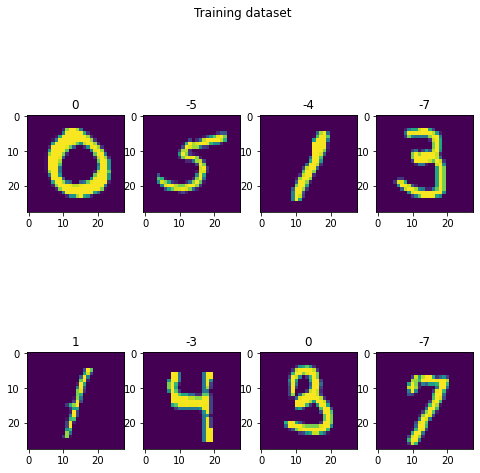

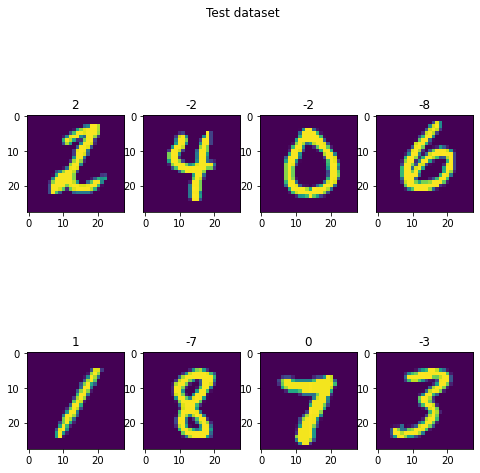

In [ ]:
# Show Train examples

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 2

for i, (img_batch, target_batch) in enumerate(train_dataset_windowed):

    for k in range(batch_size):
        
        if k == 2:
          break

        for j in range(sequence_length):

            if k == 0:

                fig.add_subplot(rows, columns, j+1)

                plt.imshow(img_batch[k][j].numpy().reshape((28,28)))
                plt.title(target_batch[k][j].numpy())

            if k == 1:

                fig.add_subplot(rows, columns, j+1+4)
                plt.imshow(img_batch[k][j].numpy().reshape((28,28)))
                plt.title(target_batch[k][j].numpy())

    break

fig.suptitle("Training dataset")

# Show Test examples

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 2

for i, (img_batch, target_batch) in enumerate(test_dataset_windowed):

    for k in range(batch_size):

        if k == 2:
          break

        for j in range(sequence_length):

            if k == 0:

                fig.add_subplot(rows, columns, j+1)

                plt.imshow(img_batch[k][j].numpy().reshape((28,28)))
                plt.title(target_batch[k][j].numpy())

            if k == 1:

                fig.add_subplot(rows, columns, j+1+4)
                plt.imshow(img_batch[k][j].numpy().reshape((28,28)))
                plt.title(target_batch[k][j].numpy())

    break

fig.suptitle("Test dataset")

In [ ]:
# class ResConvBlock(tf.keras.layers.Layer):
#     def __init__(self,depth,layer_count):
#         super(ResConvBlock,self).__init__()

#         k_in = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

#         self.entry_layer = tf.keras.layers.Conv2D(filters=depth,kernel_size=3,kernel_initializer=k_in,padding="same",activation="relu")
#         self.layers = [tf.keras.layers.Conv2D(filters=depth,kernel_size=3,kernel_initializer=k_in,padding="same",activation="relu") for _ in range(layer_count)]

#         self.bottleneck =tf.keras.layers.Conv2D(filters=depth,kernel_size=1,kernel_initializer=k_in,padding="same",activation="relu")

#     @tf.function
#     def call(self,x):

#         x = self.entry_layer(x)

#         for layer in self.layers:
#             c = self.bottleneck(x)
#             c = layer(c)
#             x += c

#         return x

# class LSTMCell(tf.keras.layers.AbstractRNNCell):

#     def __init__(self, recurrent_unit, **kwargs):
#         super().__init__(**kwargs)

#         self.h_state_size = recurrent_unit
                
#         # forget gate
#         self.linear_forget = tf.keras.layers.Dense(self.h_state_size, 
#                                                        kernel_initializer= tf.keras.initializers.Orthogonal(
#                                                            gain=1.0, seed=None),
#                                                        activation="sigmoid",use_bias=True)
#         # input gate
#         self.linear_input = tf.keras.layers.Dense(self.h_state_size, 
#                                                        kernel_initializer= tf.keras.initializers.Orthogonal(
#                                                            gain=1.0, seed=None),
#                                                        activation="sigmoid",use_bias=True)

#         # candidates
#         self.linear_candidate = tf.keras.layers.Dense(self.h_state_size, 
#                                                        kernel_initializer= tf.keras.initializers.Orthogonal(
#                                                            gain=1.0, seed=None),
#                                                        activation="tanh",use_bias=True)

#         # out gate
#         self.linear_output = tf.keras.layers.Dense(self.h_state_size, 
#                                                        kernel_initializer= tf.keras.initializers.Orthogonal(
#                                                            gain=1.0, seed=None),
#                                                        activation="sigmoid",use_bias=True)
    
#     @property
#     def state_size(self):
#         return [tf.TensorShape([self.h_state_size]), 
#                 tf.TensorShape([self.h_state_size])]
#     @property
#     def output_size(self):
#         return [tf.TensorShape([self.h_state_size])]
    
#     def get_initial_state(self, inputs=None, batch_size=64, dtype=None):
#         return [tf.zeros([batch_size,self.h_state_size]), 
#                 tf.zeros([batch_size,self.h_state_size])]

#     def call(self, inputs, states):

#         # unpack the states
#         hidden_state = states[0]
#         cell_state = states[1]

#         # concatinate input to hidden state
#         h_i = tf.concat([inputs,hidden_state],axis=1)

#         # Step 1: forget gat
#         f = self.linear_forget(h_i)

#         # Step 2: input gate
#         i = self.linear_input(h_i)

#         # Step 3: cell state candidates
#         cs_c = self.linear_candidate(h_i)

#         # Step  4: updating the cell state
#         cs_next = f * cell_state + i * cs_c

#         # Step 5: output gate
#         o = self.linear_output(h_i)

#         # Step 6: calculate next hidden state
#         h_next = o * tf.keras.activations.tanh(cs_next)

#         return h_next, [h_next, cs_next]
    
#     def get_config(self):
#         return {"Hidden_State": self.hidden_state, 
#                 "Cell_State": self.cell_state}


# class CNN_LSTM_Model(tf.keras.Model):
#     def __init__(self):
#         super().__init__()

#         # Residual Block 1
#         self.r_b_1 = ResConvBlock(24,4)
#         self.bn_1 = tf.keras.layers.BatchNormalization()
#         self.pool_1 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2,strides=2))
#         self.do_1 = tf.keras.layers.Dropout(droprate)

#         # Residual Block 2
#         self.r_b_2 = ResConvBlock(24,4)
#         self.bn_2 = tf.keras.layers.BatchNormalization()
#         self.pool_2 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2,strides=2))
#         self.do_2 = tf.keras.layers.Dropout(droprate)

#         # Residual Block 3
#         self.r_b_3 = ResConvBlock(24,4)
#         self.bn_3 = tf.keras.layers.BatchNormalization()
#         self.glob_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAvgPool2D())
#         self.do_3 = tf.keras.layers.Dropout(droprate)

#         # Fully connected layer
#         self.fc1 = tf.keras.layers.Dense(500,activation=None)
#         self.bn_4 = tf.keras.layers.BatchNormalization()
#         self.act = tf.keras.layers.ReLU()
#         self.do_4 = tf.keras.layers.Dropout(droprate)

#         # Output
#         self.out = tf.keras.layers.Dense(CNN_output_size,activation=None)
        
#         # LSTM cell
#         self.lstm_cell = LSTMCell(CNN_output_size)
        
#         # return_sequences collects and returns the output of the rnn_cell for all time-steps
#         self.lstm_layer = tf.keras.layers.RNN(self.lstm_cell, return_sequences=True)
        
#         self.output_layer = tf.keras.layers.Dense(1, activation=None)
        
#         self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
#                              tf.keras.metrics.BinaryAccuracy()]
    
#     @property
#     def metrics(self):
#         return self.metrics_list
    
#     def reset_metrics(self):
#         for metric in self.metrics:
#             metric.reset_state()
        
#     def call(self, sequence, training=False):

#         # CNN
#         x = self.r_b_1(sequence)
#         x = self.bn_1(x)
#         x = self.pool_1(x)
#         x = self.do_1(x)
#         x = self.r_b_2(x)
#         x = self.bn_2(x)
#         x = self.pool_2(x)
#         x = self.do_2(x)
#         x = self.r_b_3(x)
#         x = self.bn_3(x)
#         x = self.glob_pool(x)
#         x = self.do_3(x)
#         x = self.fc1(x)
#         x = self.bn_4(x)
#         x = self.act(x)
#         x = self.do_4(x)
#         cnn_output = self.out(x)

#         # LSTM
#         lstm_output = self.lstm_layer(cnn_output)
        
#         return self.output_layer(lstm_output)
    
#     def train_step(self, data):
        
#         """
#         Standard train_step method, assuming we use model.compile(optimizer, loss, ...)
#         """
        
#         sequence, label = data
#         with tf.GradientTape() as tape:
#             output = self(sequence, training=True)
#             loss = self.compiled_loss(label, output, regularization_losses=self.losses)
#         gradients = tape.gradient(loss, self.trainable_variables)
        
#         self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
#         self.metrics[0].update_state(loss)
#         self.metrics[1].update_state(label, output)
        
#         return {m.name : m.result() for m in self.metrics}
    
#     def test_step(self, data):
        
#         """
#         Standard test_step method, assuming we use model.compile(optimizer, loss, ...)
#         """
        
#         sequence, label = data
#         output = self(sequence, training=False)
#         loss = self.compiled_loss(label, output, regularization_losses=self.losses)
                
#         self.metrics[0].update_state(loss)
#         self.metrics[1].update_state(label, output)
        
#         return {m.name : m.result() for m in self.metrics}


In [ ]:
class ResConvBlock(tf.keras.layers.Layer):
    def __init__(self,depth,layer_count):
        super(ResConvBlock,self).__init__()

        k_in = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

        self.entry_layer = tf.keras.layers.Conv2D(filters=depth,kernel_size=3,kernel_initializer=k_in,padding="same",activation="relu")
        self.layers = [tf.keras.layers.Conv2D(filters=depth,kernel_size=3,kernel_initializer=k_in,padding="same",activation="relu") for _ in range(layer_count)]

        self.bottleneck =tf.keras.layers.Conv2D(filters=depth,kernel_size=1,kernel_initializer=k_in,padding="same",activation="relu")

    @tf.function
    def call(self,x):

        x = self.entry_layer(x)

        for layer in self.layers:
            c = self.bottleneck(x)
            c = layer(c)
            x += c

        return x

class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet,self).__init__()

        # Residual Block 1
        self.r_b_1 = ResConvBlock(24,4)
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.pool_1 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2,strides=2))
        self.do_1 = tf.keras.layers.Dropout(droprate)

        # Residual Block 2
        self.r_b_2 = ResConvBlock(24,4)
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.pool_2 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2,strides=2))
        self.do_2 = tf.keras.layers.Dropout(droprate)

        # Residual Block 3
        self.r_b_3 = ResConvBlock(24,4)
        self.bn_3 = tf.keras.layers.BatchNormalization()
        self.glob_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAvgPool2D())
        self.do_3 = tf.keras.layers.Dropout(droprate)

        # Fully connected layer
        self.fc1 = tf.keras.layers.Dense(500,activation=None)
        self.bn_4 = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.ReLU()
        self.do_4 = tf.keras.layers.Dropout(droprate)

        # Output
        self.out = tf.keras.layers.Dense(CNN_output_size,activation=None)

    @tf.function
    def call(self,x):

        x = self.r_b_1(x)
        x = self.bn_1(x)
        x = self.pool_1(x)
        x = self.do_1(x)
        x = self.r_b_2(x)
        x = self.bn_2(x)
        x = self.pool_2(x)
        x = self.do_2(x)
        x = self.r_b_3(x)
        x = self.bn_3(x)
        x = self.glob_pool(x)
        x = self.do_3(x)
        x = self.fc1(x)
        x = self.bn_4(x)
        x = self.act(x)
        x = self.do_4(x)
        x = self.out(x)

        return x

class LSTMCell(tf.keras.layers.AbstractRNNCell):

    def __init__(self, recurrent_unit, **kwargs):
        super().__init__(**kwargs)

        self.h_state_size = recurrent_unit
                
        # forget gate
        self.linear_forget = tf.keras.layers.Dense(self.h_state_size, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation="sigmoid",use_bias=True)
        # input gate
        self.linear_input = tf.keras.layers.Dense(self.h_state_size, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation="sigmoid",use_bias=True)

        # candidates
        self.linear_candidate = tf.keras.layers.Dense(self.h_state_size, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation="tanh",use_bias=True)

        # out gate
        self.linear_output = tf.keras.layers.Dense(self.h_state_size, 
                                                       kernel_initializer= tf.keras.initializers.Orthogonal(
                                                           gain=1.0, seed=None),
                                                       activation="sigmoid",use_bias=True)
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.h_state_size]), 
                tf.TensorShape([self.h_state_size])]
    @property
    def output_size(self):
        return [tf.TensorShape([self.h_state_size])]
    
    def get_initial_state(self, inputs=None, batch_size=64, dtype=None):
        return [tf.zeros([batch_size,self.h_state_size]), 
                tf.zeros([batch_size,self.h_state_size])]

    def call(self, inputs, states):

        # unpack the states
        hidden_state = states[0]
        cell_state = states[1]

        # concatinate input to hidden state
        h_i = tf.concat([inputs,hidden_state],axis=1)

        # Step 1: forget gat
        f = self.linear_forget(h_i)

        # Step 2: input gate
        i = self.linear_input(h_i)

        # Step 3: cell state candidates
        cs_c = self.linear_candidate(h_i)

        # Step  4: updating the cell state
        cs_next = f * cell_state + i * cs_c

        # Step 5: output gate
        o = self.linear_output(h_i)

        # Step 6: calculate next hidden state
        h_next = o * tf.keras.activations.tanh(cs_next)

        return h_next, [h_next, cs_next]
    
    def get_config(self):
        return {"Hidden_State": self.hidden_state, 
                "Cell_State": self.cell_state}


class CNN_LSTM_Model(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.CNN = ConvNet()
        
        self.lstm_cell = LSTMCell(CNN_output_size)
        
        # return_sequences collects and returns the output of the rnn_cell for all time-steps
        self.lstm_layer = tf.keras.layers.RNN(self.lstm_cell, return_sequences=True)
        
        self.output_layer = tf.keras.layers.Dense(1, activation=None)
        
        self.metrics_list = [tf.keras.metrics.Mean(name="loss"),
                             tf.keras.metrics.BinaryAccuracy()]
    
    @property
    def metrics(self):
        return self.metrics_list
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
        
    def call(self, sequence, training=False):

        cnn_output = self.CNN(sequence)
        
        lstm_output = self.lstm_layer(cnn_output)
        
        return self.output_layer(lstm_output)
    
    def train_step(self, data):
        
        """
        Standard train_step method, assuming we use model.compile(optimizer, loss, ...)
        """
        
        sequence, label = data
        with tf.GradientTape() as tape:
            output = self(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)
        
        return {m.name : m.result() for m in self.metrics}
    
    def test_step(self, data):
        
        """
        Standard test_step method, assuming we use model.compile(optimizer, loss, ...)
        """
        
        sequence, label = data
        output = self(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)
                
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)
        
        return {m.name : m.result() for m in self.metrics}


In [ ]:
# instantiate model
model_cnn_lstm = CNN_LSTM_Model()

# compile the model
model_cnn_lstm.compile(optimizer = optimizer, loss=loss)

In [ ]:
# show summary
model_cnn_lstm.build((batch_size,sequence_length,28,28,1))
model_cnn_lstm.summary()

Model: "cnn_lstm__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_net (ConvNet)          multiple                  114790    
                                                                 
 lstm_cell (LSTMCell)        multiple                  20200     
                                                                 
 rnn (RNN)                   multiple                  20200     
                                                                 
 dense_6 (Dense)             multiple                  51        
                                                                 
Total params: 135,045
Trainable params: 133,897
Non-trainable params: 1,148
_________________________________________________________________


In [ ]:
EXPERIMENT_NAME = "IANN_wTF_HW_7"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{current_time}")

In [ ]:
history = model_cnn_lstm.fit(train_dataset_windowed,
                    validation_data=test_dataset_windowed,
                    initial_epoch=20,
                    epochs=40,
                    callbacks=[logging_callback])

Epoch 21/40
235/235 [==============================] - 35s 84ms/step - loss: 18.6558 - binary_accuracy: 0.0844 - val_loss: 7.2682 - val_binary_accuracy: 0.0928
Epoch 22/40
235/235 [==============================] - 22s 82ms/step - loss: 4.5432 - binary_accuracy: 0.0936 - val_loss: 2.8667 - val_binary_accuracy: 0.1029
Epoch 23/40
235/235 [==============================] - 21s 79ms/step - loss: 2.5476 - binary_accuracy: 0.1097 - val_loss: 1.9702 - val_binary_accuracy: 0.1213
Epoch 24/40
235/235 [==============================] - 22s 83ms/step - loss: 1.7525 - binary_accuracy: 0.1222 - val_loss: 1.4406 - val_binary_accuracy: 0.1328
Epoch 25/40
235/235 [==============================] - 21s 80ms/step - loss: 1.3907 - binary_accuracy: 0.1290 - val_loss: 1.1782 - val_binary_accuracy: 0.1354
Epoch 26/40
235/235 [==============================] - 21s 79ms/step - loss: 1.1916 - binary_accuracy: 0.1337 - val_loss: 1.1364 - val_binary_accuracy: 0.1399
Epoch 27/40
235/235 [========================

In [22]:
#!kill 11736
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 12875), started 0:02:47 ago. (Use '!kill 12875' to kill it.)

<IPython.core.display.Javascript object>

2/2 [==============================] - 1s 18ms/step


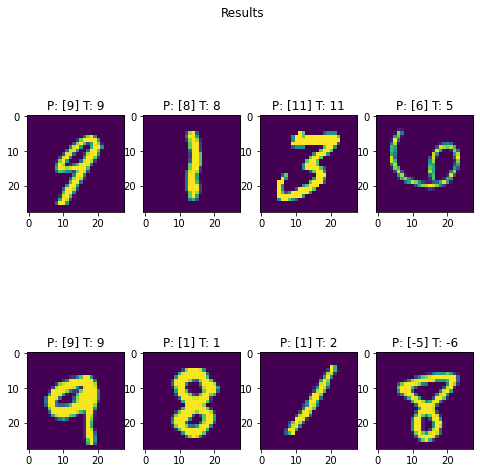

In [ ]:
# Show result

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 2

for i, (img_batch, target_batch) in enumerate(train_dataset_windowed):

    predictions = model_cnn_lstm.predict(img_batch)

    for k in range(batch_size):
        
        if k == 2:
          break

        for j in range(sequence_length):

            if k == 0:

                fig.add_subplot(rows, columns, j+1)

                plt.imshow(img_batch[k][j].numpy().reshape((28,28)))
                plt.title(f"P: {predictions[k][j].astype(int)} T: {target_batch[k][j].numpy()}")

            if k == 1:

                fig.add_subplot(rows, columns, j+1+4)
                plt.imshow(img_batch[k][j].numpy().reshape((28,28)))
                plt.title(f"P: {predictions[k][j].astype(int)} T: {target_batch[k][j].numpy()}")
    
    fig.suptitle("Results")
    break

##To DO:

Kann ich die zweite variante auch benutzen?
Transfer learning?
Loss function